# Duc Huy Nguyen - Statistics DRP Project Autumn 2025
## Relationship between Job Postings and Unemployment
### with related Economics metrics

We first import the required libraries for the project

In [1466]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
from scipy.interpolate import CubicSpline

import statsmodels.api as sm

# Import some ML models and tools from scikit_learn
from sklearn.metrics import (root_mean_squared_error, accuracy_score, confusion_matrix,
                             precision_score, recall_score, f1_score, r2_score, roc_auc_score)
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC

# Use external library to plot our decision regions
from mlxtend.plotting import plot_decision_regions


In [1467]:
# Suppress irrelevant warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(
    "ignore",
    message="KNOWN BUG: p-values computed in this summary are likely much smaller than they should be.",
    category=UserWarning
)

## Loading data and preliminary processing
We then load relevant datasets on job postings, unemployment, interest rates, inflation, stock prices and GDP into our notebook.

In [1468]:
natural_unemp_df = pd.read_csv('Data/quarterly_natural_unemp.csv')
unemp_df = pd.read_csv('Data/monthly_unemployment_rate.csv') # Read Unemployment data
cpi_df = pd.read_csv('Data/monthly_cpi.csv') # Read CPI data
gdp_df = pd.read_csv('Data/quarterly_gdp.csv')# Read GDP data
job_df = pd.read_csv('Data/monthly_job_postings.csv')# Read Job Postings
sp500_df = pd.read_csv('Data/monthly_sp500.csv') # Read S&P 500 data
bond_df = pd.read_csv('Data/monthly_bonds.csv') # Read the bonds data
interest_df = pd.read_csv('Data/monthly_federal_funds_rate.csv') # Read the interest rates data
assault_df = pd.read_csv('Data/monthly_assault.csv')
continuing_jobless_df = pd.read_csv('Data/monthly_continuing_jobless_claims.csv')
jobquit_df = pd.read_csv('Data/monthly_job_quit.csv')
jobless_df = pd.read_csv('Data/monthly_jobless_claims.csv')
labor_df = pd.read_csv('Data/monthly_labor.csv')

In [1469]:
# We estimate the inflation rate from CPI
inflation_df = cpi_df.copy()
inflation_df['inflation_rate'] = ((inflation_df['CPIAUCSL'] 
                                - inflation_df['CPIAUCSL'].shift(1)) / inflation_df['CPIAUCSL'].shift(1) ) * 100
inflation_df.drop(['CPIAUCSL'], axis=1, inplace=True)
inflation_df.dropna(inplace=True)

We format the time for our Dataframe 

In [1470]:
for df in [natural_unemp_df, unemp_df, cpi_df, gdp_df, job_df, bond_df, inflation_df, interest_df,
           continuing_jobless_df, jobquit_df, jobless_df, labor_df]: # format dates for data got from FRED
    df.rename(columns={'observation_date' : 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

We then format the monthly stock price

In [1471]:
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df.set_index('date', inplace=True)

In [1472]:
# Resample the bonds returns and jobless claims
bond_df = bond_df.resample('MS').first()
continuing_jobless_df = continuing_jobless_df.resample('MS').sum().dropna()
jobless_df = jobless_df.resample('MS').sum().dropna()

In [1473]:
# Format assault count month
assault_df['Month'] = pd.to_datetime(assault_df['Month'], format='%m-%Y')
assault_df['Month'] = assault_df['Month'].dt.to_period('M').dt.to_timestamp()

assault_df.rename(columns={'Month': 'date'}, inplace=True)
assault_df.set_index('date', inplace=True)

### Estimating quarterly GDP from monthly GDP through interpolation

We then try to estimate the monthly GDP data using resampling and interpolation in Python.  
We are using linear spline to predict the months within 2025 Q3 without available data (this would be updated by FRED in Nov 26th 2025)

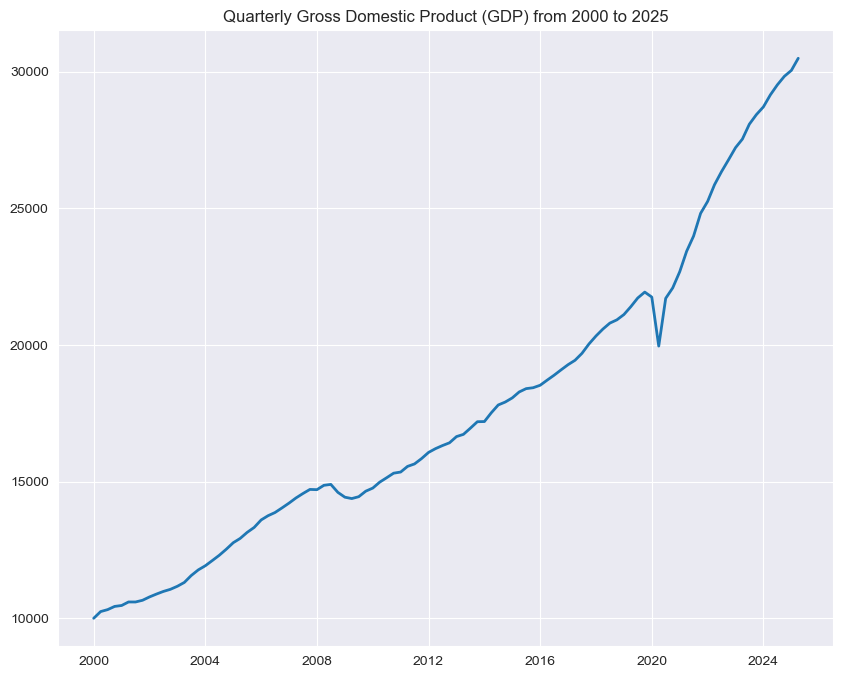

In [1474]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Quarterly Gross Domestic Product (GDP) from 2000 to 2025')
plt.show()

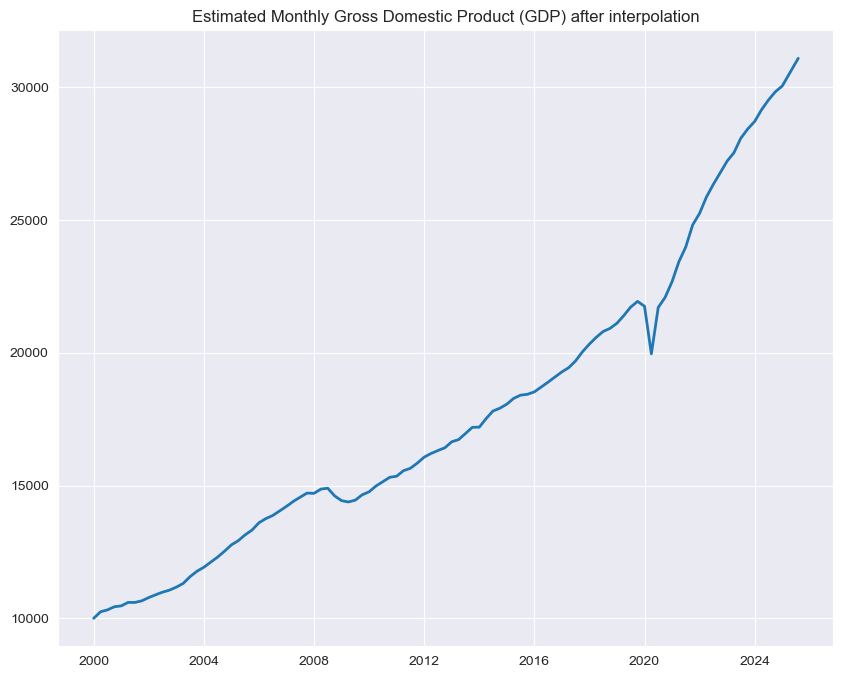

In [1475]:
# We extend our current date time into the future
future_dates = pd.to_datetime(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])
extended_index = gdp_df.index.union(future_dates)

# print(extended_index)
gdp_df = gdp_df.reindex(extended_index)

# Then we interpolate the data 
gdp_df = gdp_df.resample('MS')
gdp_df = gdp_df.interpolate(method='spline', order = 1)

# Check the data after interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Estimated Monthly Gross Domestic Product (GDP) after interpolation')
plt.show()

### Estimating the monthly Natural Unemployment rate from quarterly rate


We then try to estimate the monthly natural rate of unemployment (NAIRU) data using resampling and interpolation in Python.  


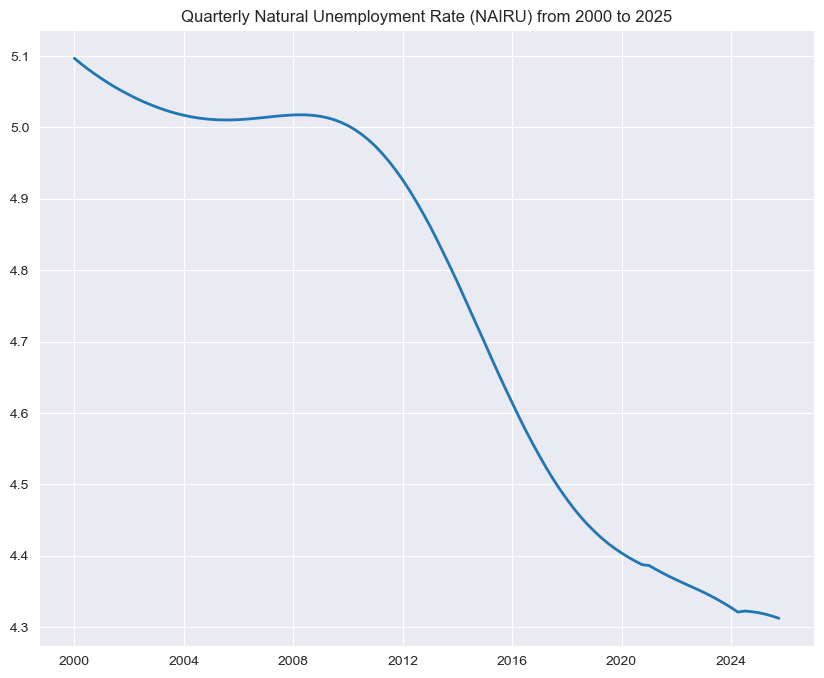

In [1476]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], linewidth=2, markersize=12)
plt.title('Quarterly Natural Unemployment Rate (NAIRU) from 2000 to 2025')
plt.show()

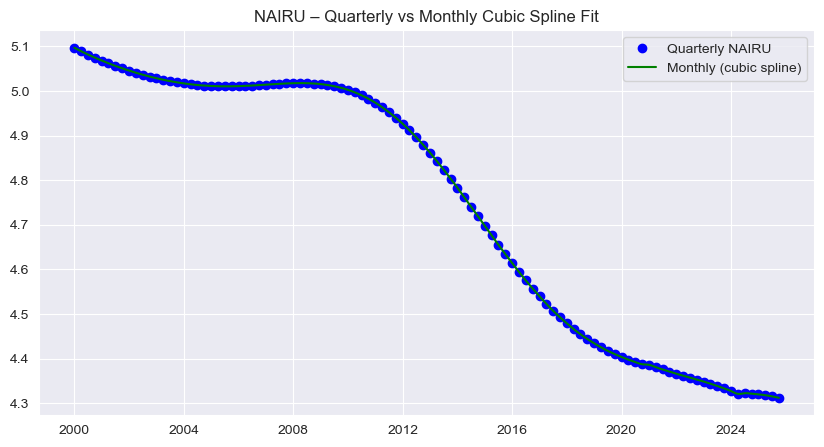

In [1477]:
# With the pattern being represented, we use cubic spline interpolation to fit monthly data
# We interpolate the data 
# natural_unemp_df = natural_unemp_df.resample('MS')

# cubic spline with “natural” boundary conditions to reduce edge wiggles
cs = CubicSpline(natural_unemp_df.index.view('int64'), natural_unemp_df['NROU'], bc_type='natural')

# monthly dates from first to last quarter
monthly_natural_unemp_df = natural_unemp_df.resample('MS').first()
x_m = monthly_natural_unemp_df.index.view('int64')

nairu_monthly_cs = pd.DataFrame(cs(x_m), 
        index=monthly_natural_unemp_df.index, 
        columns=['NROU']
)

plt.figure(figsize=(10, 5))
plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], 'o', color='blue', label='Quarterly NAIRU')
plt.plot(nairu_monthly_cs.index, nairu_monthly_cs['NROU'], color='green', label='Monthly (cubic spline)')
plt.legend()
plt.title('NAIRU – Quarterly vs Monthly Cubic Spline Fit')
plt.show()

natural_unemp_df = nairu_monthly_cs.copy()

## Data Cleaning and Formatting 

In [1478]:
print(cpi_df.head(5))
print(unemp_df.head(5))
print(job_df.head(5))
print(sp500_df.head(5))
print(bond_df.head(5))
print(interest_df.head(5))
print(gdp_df.head(5))
print(natural_unemp_df.head(5))

            CPIAUCSL
date                
2000-01-01     169.3
2000-02-01     170.0
2000-03-01     171.0
2000-04-01     170.9
2000-05-01     171.2
            UNRATE
date              
2000-01-01     4.0
2000-02-01     4.1
2000-03-01     4.0
2000-04-01     3.8
2000-05-01     4.0
            JTSJOL
date              
2000-12-01    5088
2001-01-01    5234
2001-02-01    5097
2001-03-01    4762
2001-04-01    4615
                  SPY
date                 
1999-08-01  82.999374
1999-09-01  81.145393
1999-10-01  86.345009
1999-11-01  87.782784
1999-12-01  92.795937
            DGS10
date             
2000-01-01   6.58
2000-02-01   6.62
2000-03-01   6.39
2000-04-01   6.00
2000-05-01   6.29
            FEDFUNDS
date                
2000-01-01      5.45
2000-02-01      5.73
2000-03-01      5.85
2000-04-01      6.02
2000-05-01      6.27
                     GDP
2000-01-01  10002.179000
2000-02-01  10085.816288
2000-03-01  10163.985130
2000-04-01  10247.720000
2000-05-01  10270.876805
          

In [1479]:
# Sanity check on the index type
assert (type(job_df.index) == type(sp500_df.index) == type(inflation_df.index)
        == type(cpi_df.index) == type(unemp_df.index)
        == type(gdp_df.index) == type(interest_df.index)
        == type(natural_unemp_df.index) == type(bond_df.index) == pd.DatetimeIndex)


In [1480]:
# Count the number of Nan values
print(cpi_df.isna().sum())
print(unemp_df.isna().sum())
print(job_df.isna().sum())
print(sp500_df.isna().sum())
print(interest_df.isna().sum())
print(bond_df.isna().sum())
print(gdp_df.isna().sum())
print(inflation_df.isna().sum())

CPIAUCSL    0
dtype: int64
UNRATE    0
dtype: int64
JTSJOL    0
dtype: int64
SPY    0
dtype: int64
FEDFUNDS    0
dtype: int64
DGS10    0
dtype: int64
GDP    0
dtype: int64
inflation_rate    0
dtype: int64


In [1481]:
# Include another Dummy Variables for which Party is winning presidency
dates = pd.date_range(start = "2000-10-01", end = "2025-08-01", freq = "MS")

# Determine the presidency 
def president_party(date):
    if (date < pd.Timestamp("2000-01-20")  # Bill Clinton
            or pd.Timestamp("2009-01-20") < date < pd.Timestamp("2017-01-20") # Obama
            or pd.Timestamp("2021-01-20") < date < pd.Timestamp("2025-01-20")): # Biden
        return "Dem"
    else:
        return "Rep"
    
party_df = pd.DataFrame({
    "date": dates,
    "party": [president_party(d) for d in dates]
})

# Dummy variable: 1 = Republican, 0 = Democrat
party_df["party"] = (party_df["party"] == "Rep").astype(int)
party_df.set_index('date', inplace = True)

In [1482]:
print(assault_df.index)

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01',
               '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01',
               '2025-10-01', '2025-11-01'],
              dtype='datetime64[ns]', name='date', length=311, freq=None)


In [1483]:
# Join those data together
joined_df = cpi_df.join(unemp_df, how='right')
joined_df = joined_df.join(natural_unemp_df, how='left')
joined_df = joined_df.join(gdp_df, how='left')
joined_df = joined_df.join(job_df, how='right')
joined_df = joined_df.join(inflation_df, how='left')
joined_df = joined_df.join(interest_df, how='left')
joined_df = joined_df.join(bond_df, how='left')
joined_df = joined_df.join(sp500_df, how='inner')
joined_df = joined_df.join(party_df, how='left')
joined_df = joined_df.join(assault_df, how='left')
joined_df = joined_df.join(continuing_jobless_df, how='left')
joined_df = joined_df.join(jobquit_df, how='left')
joined_df = joined_df.join(jobless_df, how='left')
joined_df = joined_df.join(labor_df, how='left')

In [1484]:
print(joined_df.columns.tolist())

['CPIAUCSL', 'UNRATE', 'NROU', 'GDP', 'JTSJOL', 'inflation_rate', 'FEDFUNDS', 'DGS10', 'SPY', 'party', 'Crime_count', 'CCSA', 'JTSQUR', 'ICSA', 'PAYEMS']


In [1485]:
# Rename column names for easier use 
joined_df.rename(columns={
    'NROU' : 'natural_unemp',
    'CPIAUCSL' : 'cpi',
    'UNRATE' : 'unemp',
    'JTSJOL' : 'job_postings',
    'FEDFUNDS' : 'interest_rate',
    'DGS10' : 'bond',
    'SPY' : 'sp500',
    'Crime_count' : 'crime',
    'CSCICP03USM665S' : 'consumer_conf',
    'CCSA' : 'continued_claims',
    'JTSQUR' : 'quit',
    'ICSA' : 'initial_claims',
    'PAYEMS' : 'labor participation'
}, inplace=True)

In [1486]:
# Create a new dummy variable for when unemployment rate is above natural rate of unemloyment
joined_df['unemp_higher_than_natural'] = np.where(
    joined_df['unemp'] > joined_df['natural_unemp'],
    1, 0)

## Exploratory Data Analysis

We then examine our datasets before building our machine learning model 

In [1487]:
joined_df.head(5)

cpi  unemp  natural_unemp           GDP  job_postings  \
date                                                                  
2000-12-01  174.6    3.9       5.070404  10458.684220          5088   
2001-01-01  175.6    4.2       5.068230  10470.231000          5234   
2001-02-01  176.0    4.2       5.066076  10514.637779          5097   
2001-03-01  176.1    4.3       5.064155  10554.585284          4762   
2001-04-01  176.4    4.4       5.062071  10599.000000          4615   

            inflation_rate  interest_rate  bond      sp500  party   crime  \
date                                                                        
2000-12-01        0.229621           6.40  5.52  83.756271      1  143636   
2001-01-01        0.572738           5.98  4.92  87.480011      1   56365   
2001-02-01        0.227790           5.49  5.10  79.135498      1   50725   
2001-03-01        0.056818           5.31  4.87  74.700928      1   61147   
2001-04-01        0.170358           4.80  4.98  81.083435      1   64005   

            continued_claims  quit  initial_claims  labor participation  \
date                                                                      
2000-12-01          11532000   2.2         1730000               132716   
2001-01-01           9583000   2.4         1360000               132703   
2001-02-01           9946000   2.3         1485000               132788   
2001-03-01          12927000   2.3         1936000               132751   
2001-04-01          10789000   2.4         1587000               132457   

            unemp_higher_than_natural  
date                                   
2000-12-01                          0  
2001-01-01                          0  
2001-02-01                          0  
2001-03-01                          0  
2001-04-01                          0

In [1488]:
joined_df.tail(5)

cpi  unemp  natural_unemp           GDP  job_postings  \
date                                                                    
2025-04-01  320.321    4.2       4.318228  30485.729000          7395   
2025-05-01  320.580    4.2       4.317423  30633.378449          7712   
2025-06-01  321.500    4.1       4.316535  30786.057742          7357   
2025-07-01  322.132    4.2       4.315608  30933.811896          7208   
2025-08-01  323.364    4.3       4.314575  31086.491188          7227   

            inflation_rate  interest_rate  bond       sp500  party  crime  \
date                                                                        
2025-04-01        0.220891           4.33  4.17  551.376831      1  61072   
2025-05-01        0.080856           4.33  4.25  586.028015      1  64548   
2025-06-01        0.286980           4.33  4.46  616.141785      1  63112   
2025-07-01        0.196579           4.33  4.26  630.332458      1  63738   
2025-08-01        0.382452           4.33  4.23  643.266602      1  58108   

            continued_claims  quit  initial_claims  labor participation  \
date                                                                      
2025-04-01           7491000   2.0          904000               159433   
2025-05-01           9530000   2.0         1170000               159452   
2025-06-01           7811000   2.0          965000               159439   
2025-07-01           7801000   2.0          885000               159511   
2025-08-01           9713000   1.9         1150000               159507   

            unemp_higher_than_natural  
date                                   
2025-04-01                          0  
2025-05-01                          0  
2025-06-01                          0  
2025-07-01                          0  
2025-08-01                          0

In [1489]:
# Count the number of Nan values
print(joined_df.isna().sum())

cpi                          0
unemp                        0
natural_unemp                0
GDP                          0
job_postings                 0
inflation_rate               0
interest_rate                0
bond                         0
sp500                        0
party                        0
crime                        0
continued_claims             0
quit                         0
initial_claims               0
labor participation          0
unemp_higher_than_natural    0
dtype: int64


In [1490]:
# Total number of observations and date range
print(f'Total number of observations is {len(joined_df)}')
print(joined_df.columns.tolist())
joined_df.shape

Total number of observations is 297
['cpi', 'unemp', 'natural_unemp', 'GDP', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'crime', 'continued_claims', 'quit', 'initial_claims', 'labor participation', 'unemp_higher_than_natural']


(297, 16)

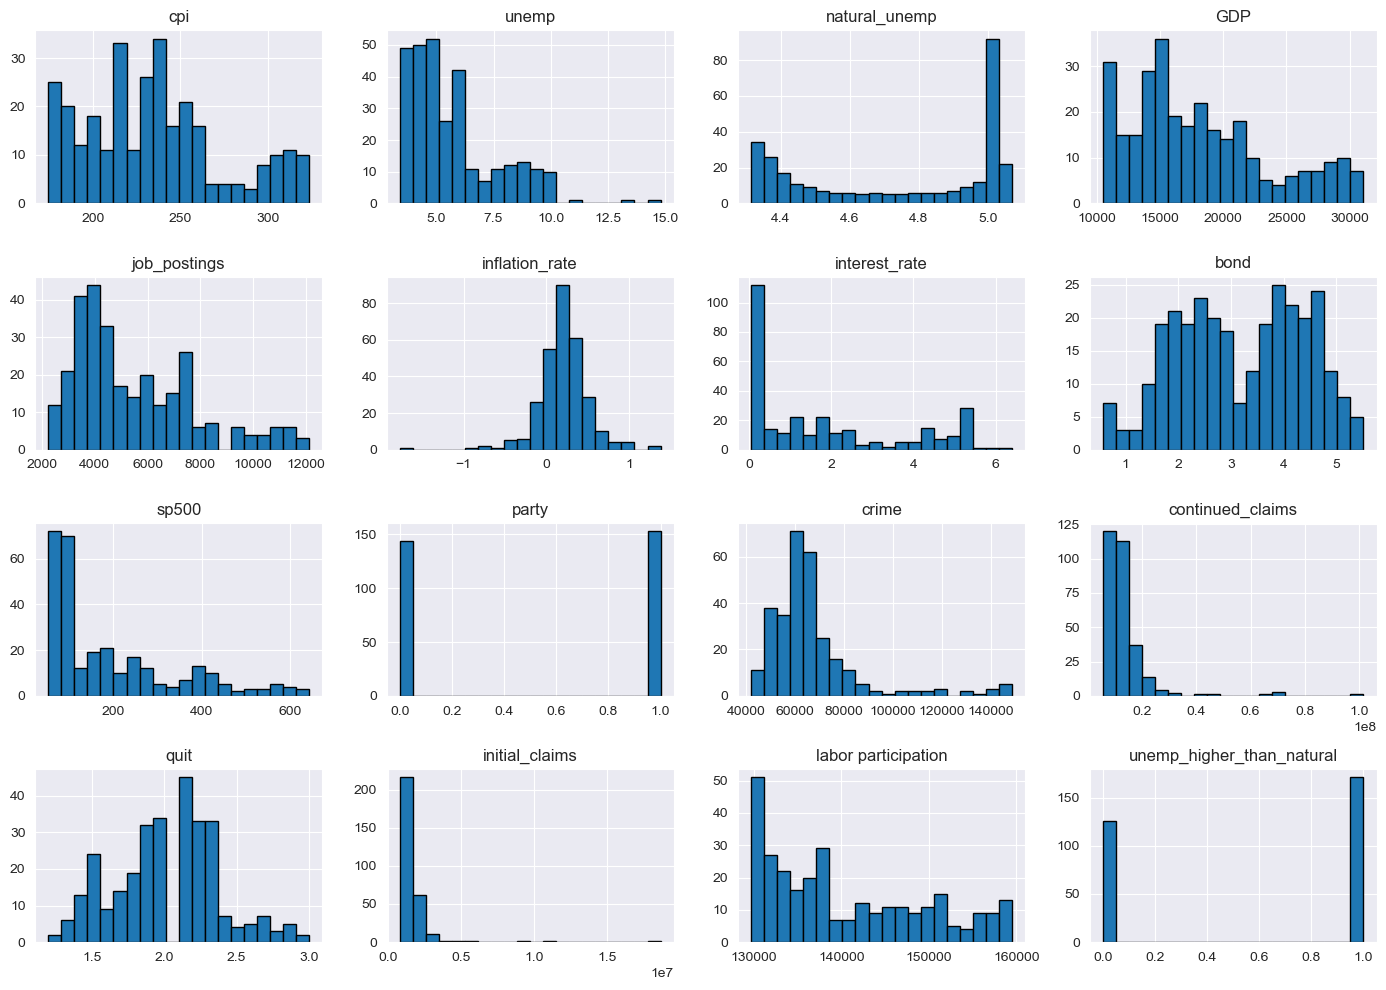

In [1491]:
joined_df.hist(bins=20, figsize=(14, 10), edgecolor='black')
plt.tight_layout()
plt.show()

Sources: Job Postings (in thousands) - From the Bureau of Labor Statistics  
Bonds prices taken from Vanguard's BND which focus on wide spectrum of bonds - Yahoo Finance  
Federal Fund Rate (the rate at which banks with each other at the end of night) - Federal Reserve Bank of ST.LOUIS  
CPI, Unemployment rate, S&P 500 - Federal Reserve Bank of ST.LOUIS

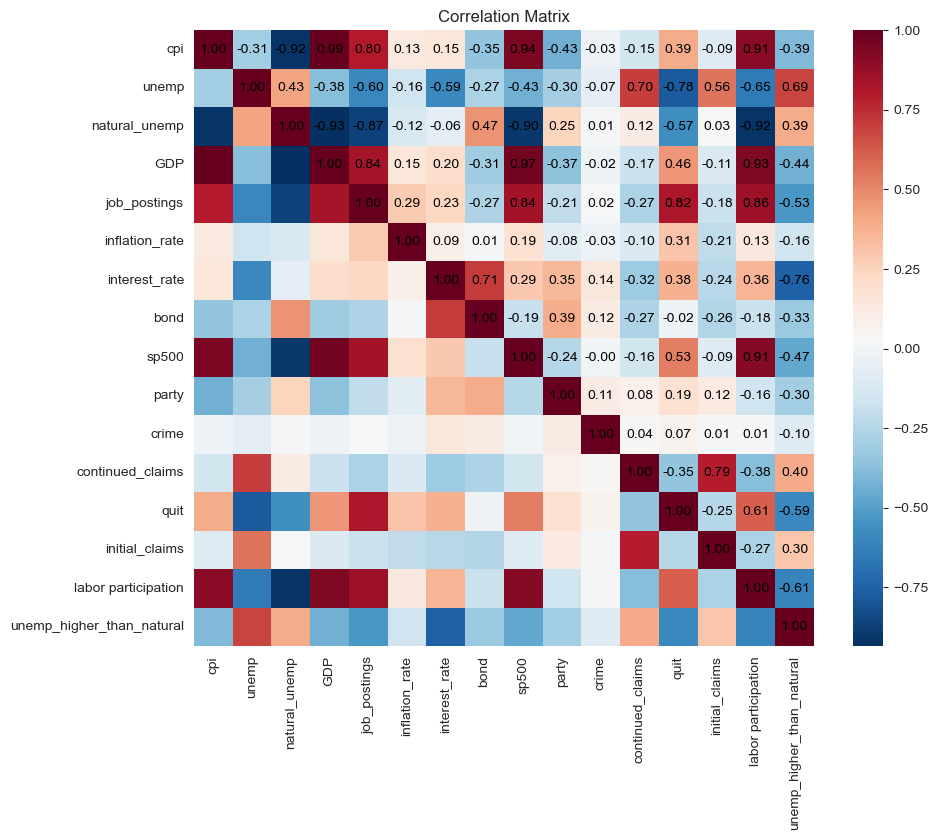

In [1492]:
# Explore the correlation between variables
corr_mat = joined_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, cmap='RdBu_r', ax=ax, cbar=True)

for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]): # upper triangle only
        val = corr_mat.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix")
plt.savefig("Visualizations/CorrMat.png", dpi=300, bbox_inches="tight")
plt.show()

Interestingly, GDP and CPI has the correlation of 1.  
We can also see that GDP and S&P500 has high correlation of 0.98, CPI and S&P500 has high correlation of 0.97  
GDP and job postings also has correlation up to 0.84

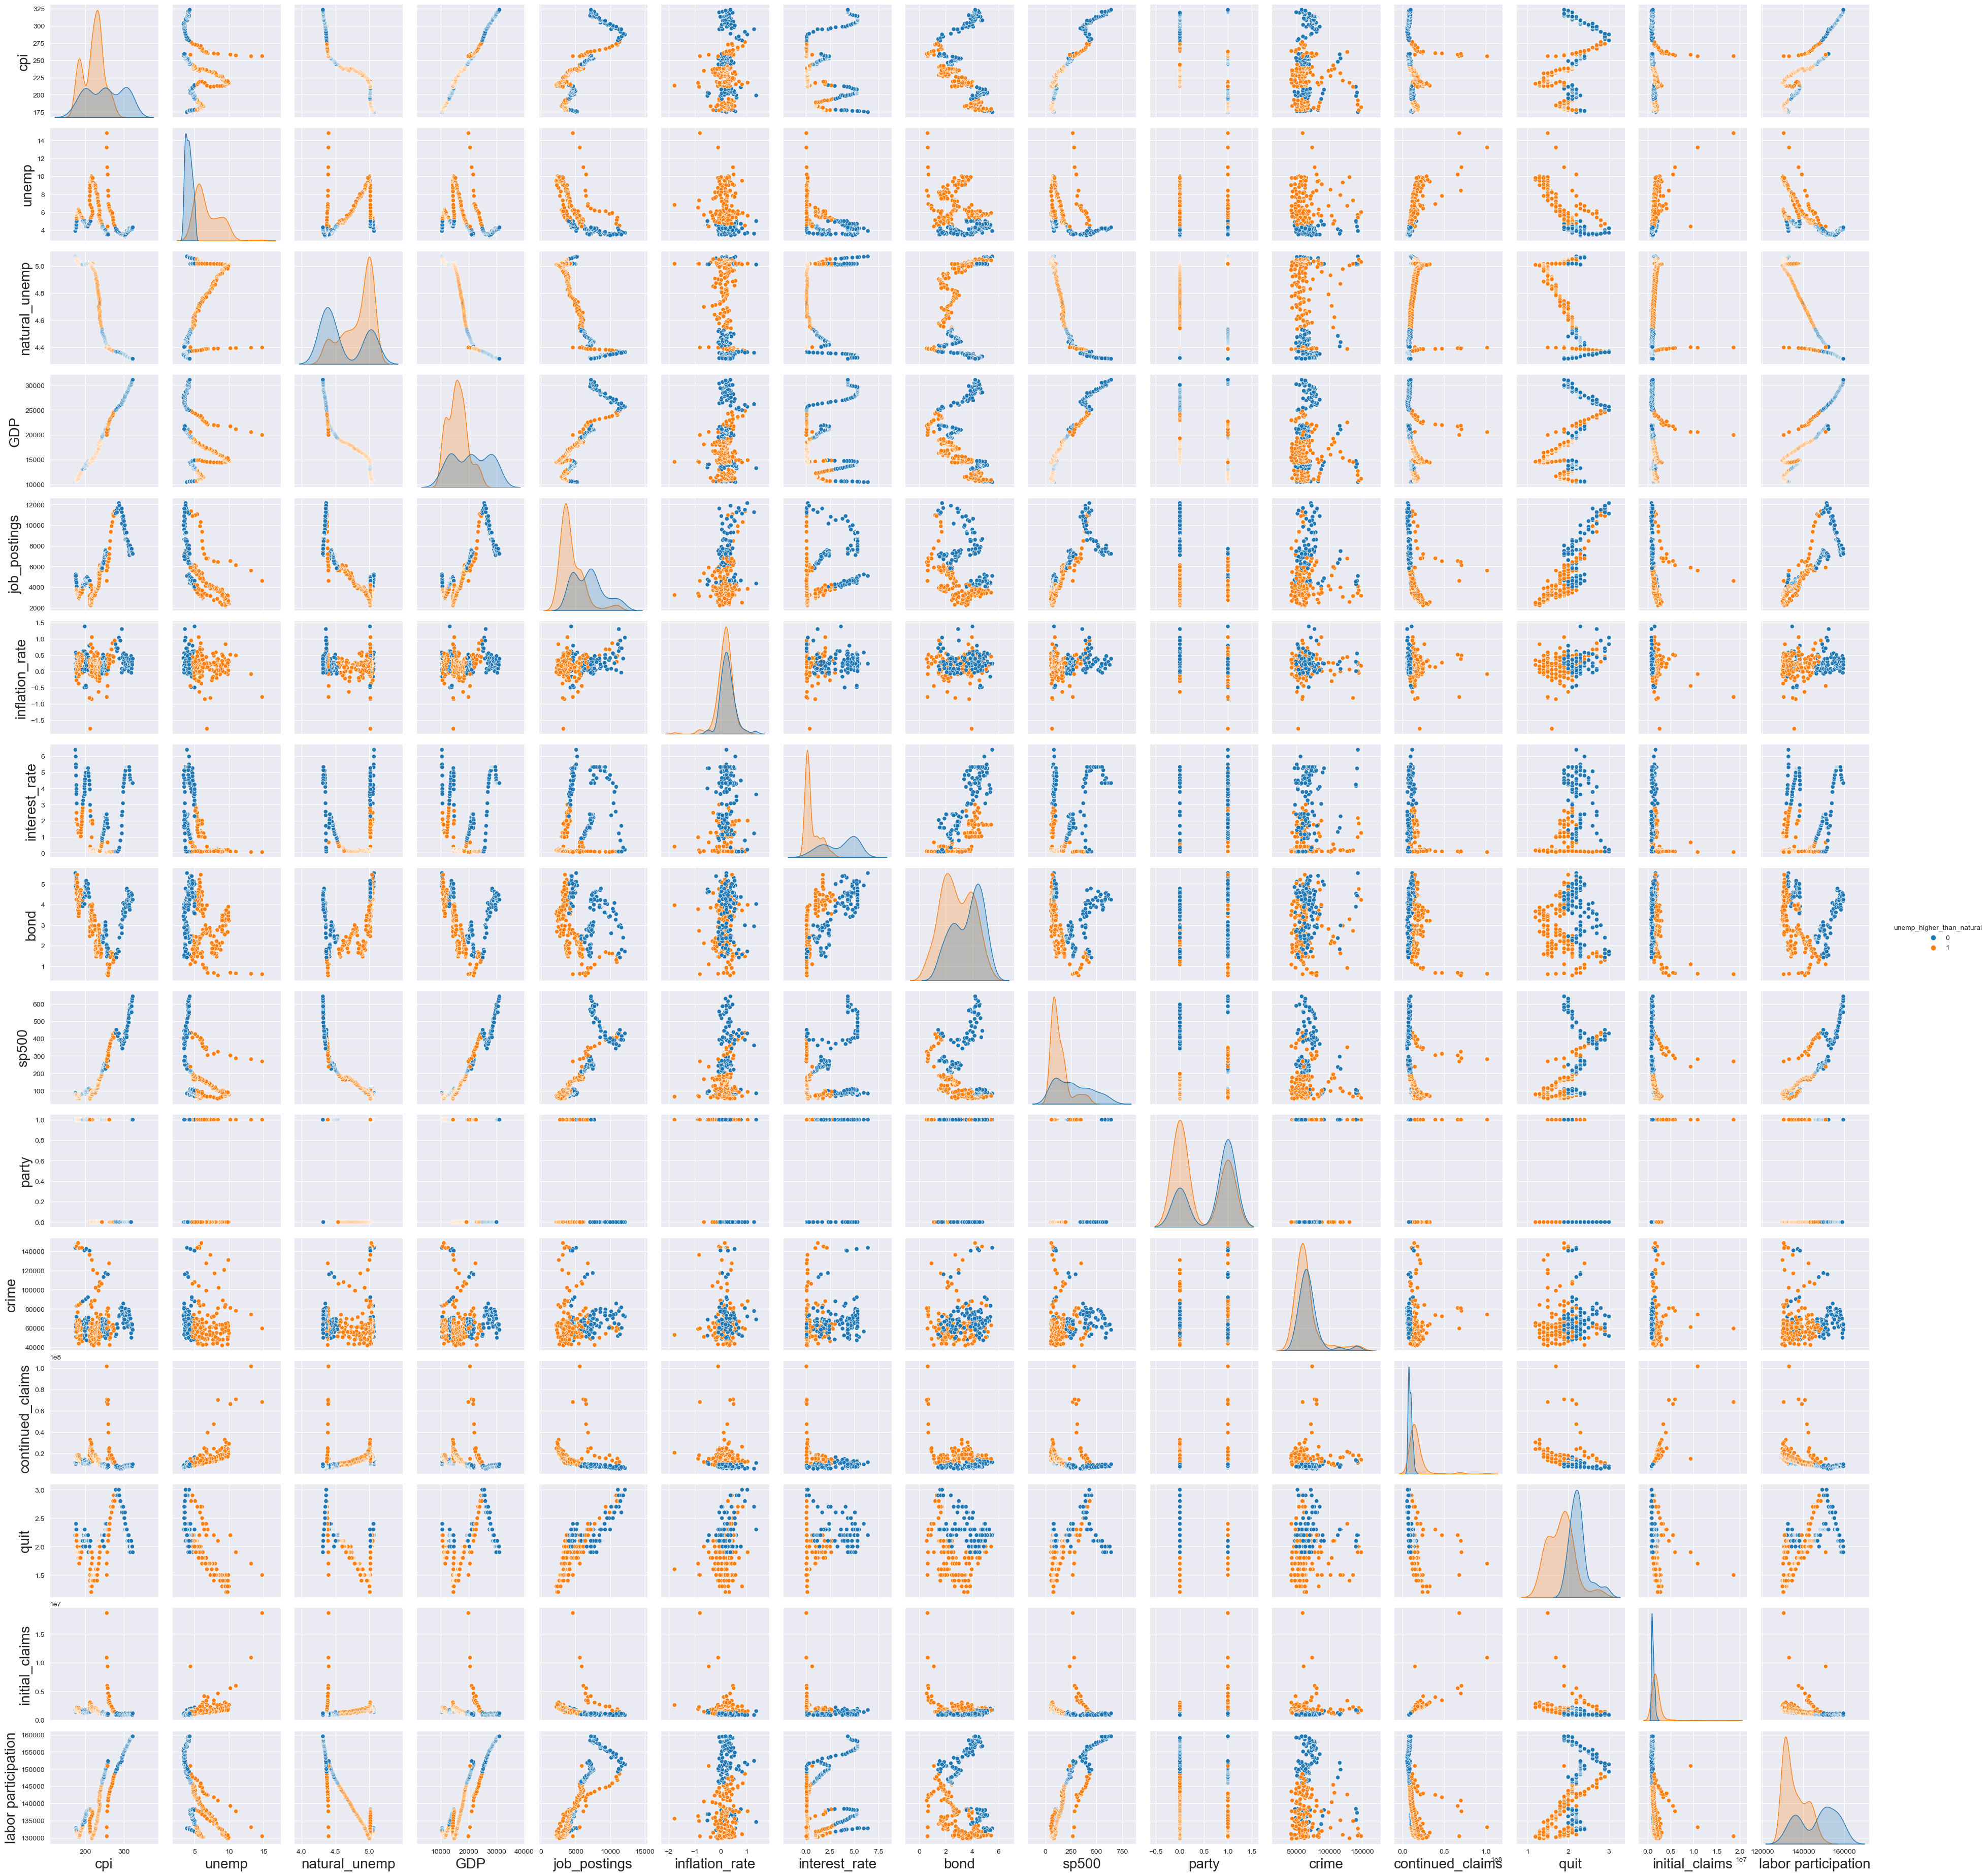

In [1493]:
# Pairplots representing the relationships between variables
g = sns.pairplot(joined_df, hue = 'unemp_higher_than_natural')
# Blue for lower, Orange for higher
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig("Visualizations/PairsPlot.png", dpi=300, bbox_inches="tight")
plt.show()

As we can see, the relationship between variables are not linear apart from pairs that have high correlation like CPI and GDP,  
and GDP and SP500

## Fitting Models

Since we can see that not all relationship of variables with Unemployment are linear  
and we want to interpret the relationship between Job Postings and Unemployment here  
So we can try Generalized Additive Models before fitting more complex non-parametric methods

### Adjustments for Multicollinearity and Add Time Adjustments

We realized from our pairs plot and correlation matrix that some predictors are highly correlated i.e. GDP and CPI, GDP and SP500

In [1494]:
new_df = joined_df.drop(["unemp_higher_than_natural", "unemp", "natural_unemp"], axis=1)
corr_mat = new_df.corr()

eigvals, eigvecs = np.linalg.eig(corr_mat)

# Sort by largest eigenvalue
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# Keep proper feature names
eigvals = pd.Series(eigvals, name="eigenvalue")
eigvecs = pd.DataFrame(
    eigvecs,
    index= new_df.columns,
    columns=[f"eigvec_{i}" for i in range(len(eigvals))]
)

In [1495]:
# Calculate Ratio = max eigenvalue / all eigenvalues
ratio = eigvals.iloc[0] / eigvals
# Identify which element of the ratio vector is highest
k = ratio.idxmax()     # eigenvector index with highest ratio
print("Index of dominant eigenvector:", k)
print("Highest ratio:", ratio[k])

# Look at the corresponding vector
dominant_vec = eigvecs[f"eigvec_{k}"]
dominant_vec

Index of dominant eigenvector: 12
Highest ratio: 6094.245629306


cpi                   -0.595126
GDP                    0.789007
job_postings          -0.004627
inflation_rate         0.004120
interest_rate          0.001253
bond                   0.002107
sp500                 -0.138789
party                 -0.006567
crime                 -0.001251
continued_claims      -0.013494
quit                  -0.023704
initial_claims         0.012793
labor participation   -0.055084
Name: eigvec_12, dtype: float64

In [1496]:
# Identify the two largest elements
top2 = dominant_vec.abs().nlargest(2)
print("Most collinear variables:\n")
print(top2)

Most collinear variables:

GDP    0.789007
cpi    0.595126
Name: eigvec_12, dtype: float64


**This means that CPI and GDP are sources of multicollinearity**  
This reference is consistent with our analysis of the pairs plot and correlation matrix

### Split Train and Test dataset

In [1497]:
split_index = int(len(joined_df) * 0.8)
joined_df.drop(top2.index.tolist(), axis = 1, inplace=True)
dropped = joined_df.drop(['unemp_higher_than_natural'], axis = 1)
predictor_columns = dropped.drop(['unemp'], axis=1).columns.tolist()
print(predictor_columns)
train = dropped.iloc[:split_index]
test = dropped.iloc[split_index:]
print(train.shape, test.shape)

['natural_unemp', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'crime', 'continued_claims', 'quit', 'initial_claims', 'labor participation']
(237, 13) (60, 13)


In [1498]:
train_X, train_Y = (train.drop(['unemp'], axis=1),
                    train['unemp'])
test_X, test_Y = (test.drop(['unemp'], axis=1),
                  test['unemp'])
print(train_X.shape)
print(test_X.shape)
print(np.isnan(train_X).sum(axis=0))
print(np.isnan(test_X).sum(axis=0))

(237, 12)
(60, 12)
natural_unemp          0
job_postings           0
inflation_rate         0
interest_rate          0
bond                   0
sp500                  0
party                  0
crime                  0
continued_claims       0
quit                   0
initial_claims         0
labor participation    0
dtype: int64
natural_unemp          0
job_postings           0
inflation_rate         0
interest_rate          0
bond                   0
sp500                  0
party                  0
crime                  0
continued_claims       0
quit                   0
initial_claims         0
labor participation    0
dtype: int64


In [1499]:
print(train_Y.shape)
print(test_Y.shape)

(237,)
(60,)


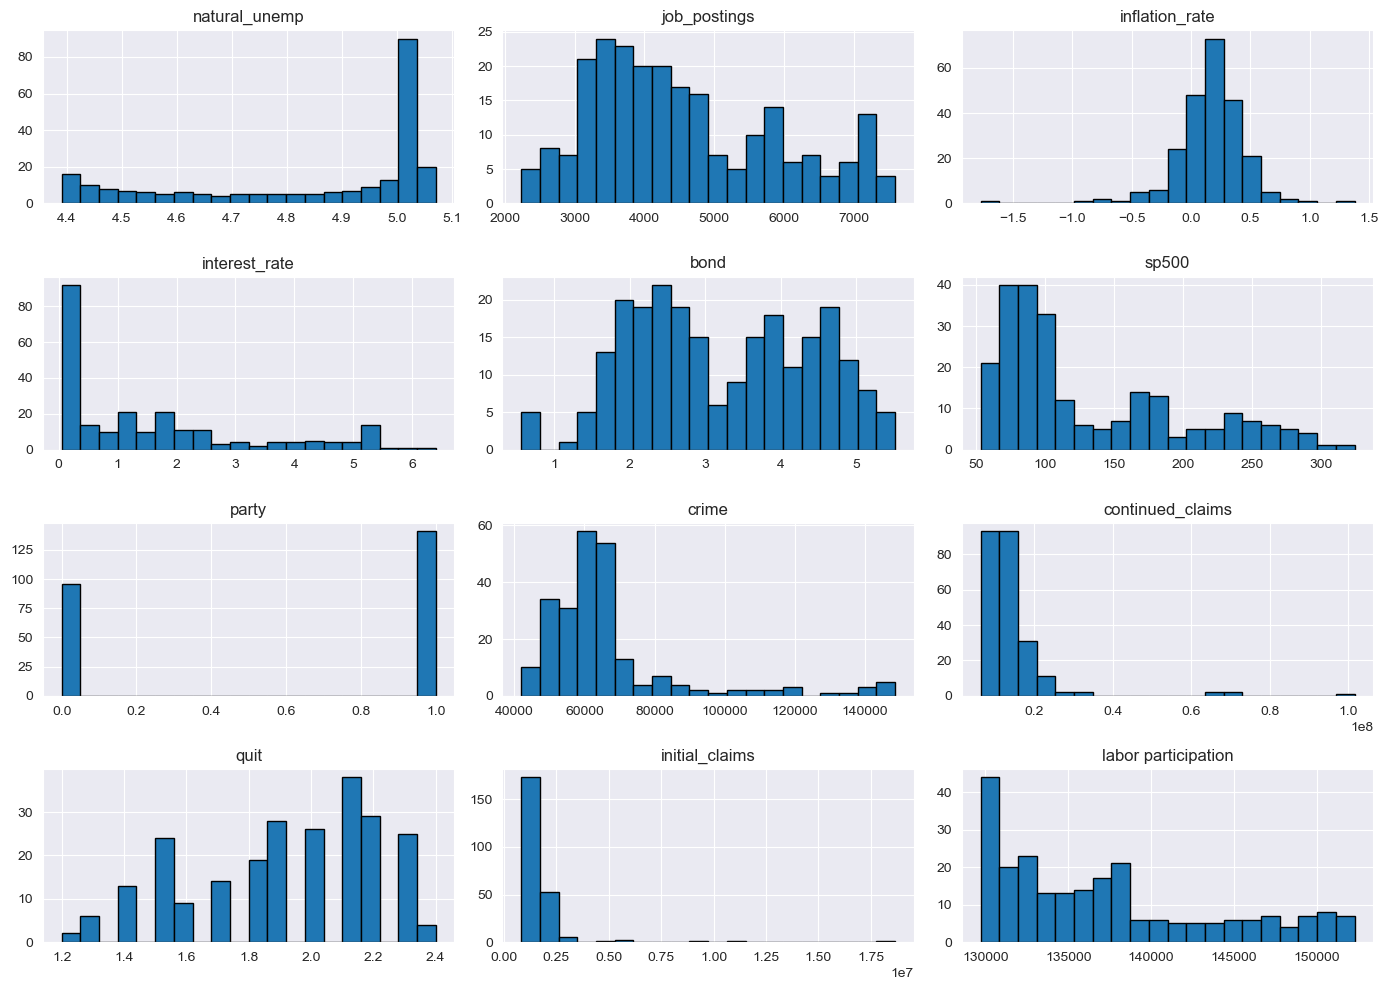

In [1500]:
train_X.hist(bins=20, figsize=(14, 10), edgecolor='black')
plt.tight_layout()
plt.show()

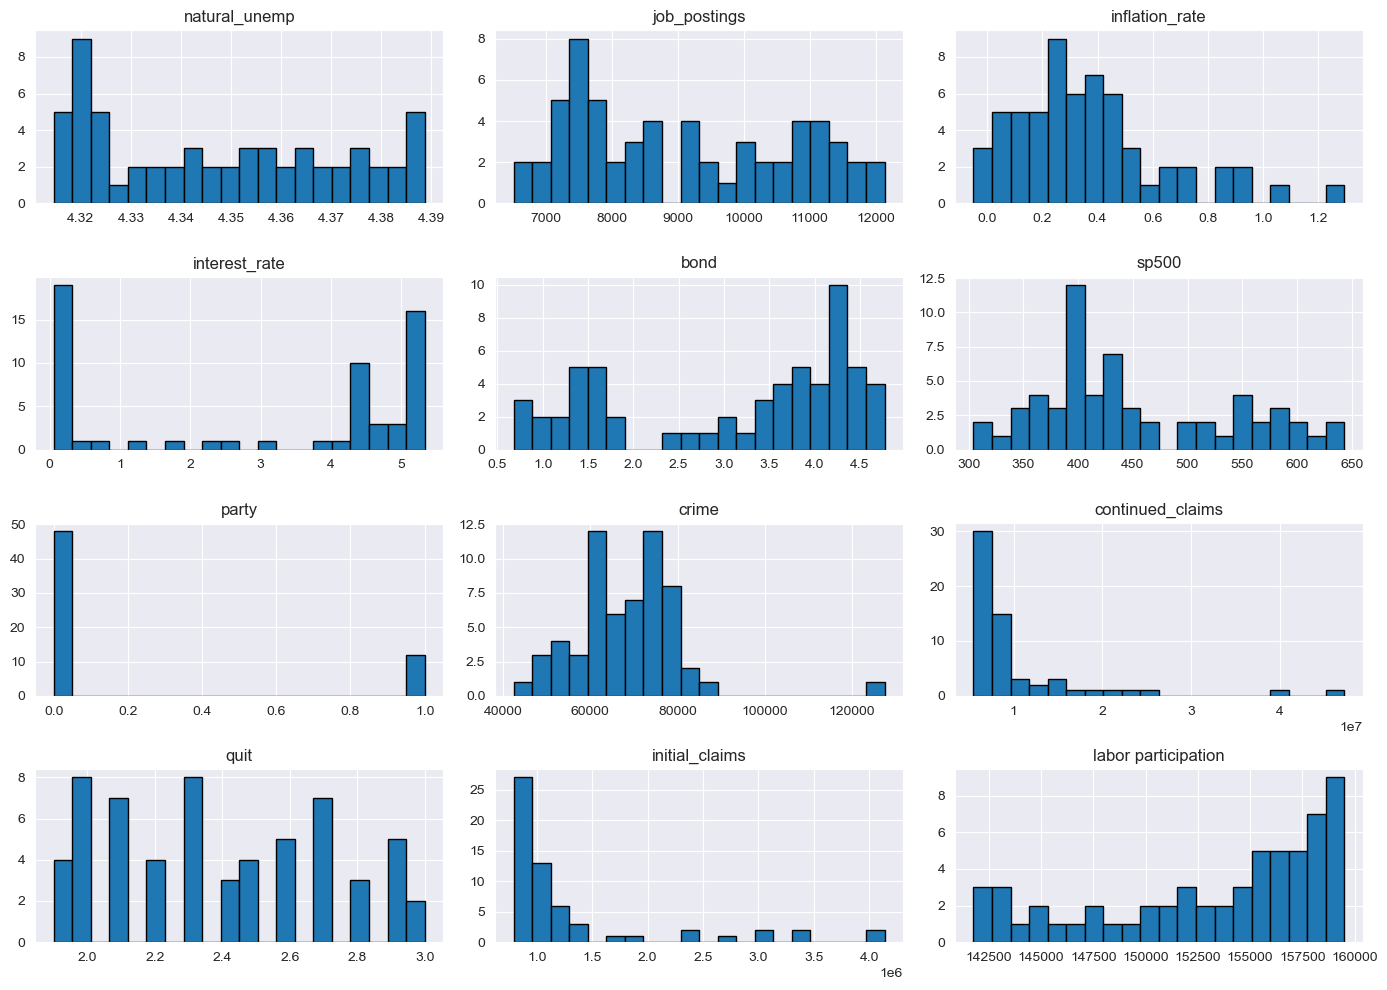

In [1501]:
test_X.hist(bins=20, figsize=(14, 10), edgecolor='black')
plt.tight_layout()
plt.show()

### Standardization

In [1502]:
# Scale X
cols_to_scale = train_X.drop(['party'], axis=1).columns.tolist()

train_X_scaled = train_X.copy()
test_X_scaled = test_X.copy()

scaler = StandardScaler()
scaler.fit(train_X[cols_to_scale])
train_X_scaled[cols_to_scale] = scaler.transform(train_X_scaled[cols_to_scale])
test_X_scaled[cols_to_scale] = scaler.transform(test_X_scaled[cols_to_scale])

print(train_X_scaled.shape)
print(test_X_scaled.shape)

(237, 12)
(60, 12)


In [1503]:
y_scaler = StandardScaler()
y_scaler.fit(train_Y.values.reshape(-1, 1))

train_Y_scaled = y_scaler.transform(train_Y.values.reshape(-1, 1)).ravel()
test_Y_scaled  = y_scaler.transform(test_Y.values.reshape(-1, 1)).ravel()

### Multiple Linear Regression + Ridge + Lasso

In [1504]:
def evaluate_linear_model(model, train_X, train_Y, test_X, test_Y):
    """
    Evaluate a regression model with:
      - Cross-validated RMSE, MAE, R²
      - Train vs Test RMSE
    """
    
    # ----- Choose CV strategy -----
    cv = skm.TimeSeriesSplit(n_splits=5)

    # ----- Cross-validated RMSE -----
    cv_mse_scores = skm.cross_val_score(
        model, train_X, train_Y,
        cv=cv, scoring="neg_mean_squared_error"
    )
    cv_rmse = np.sqrt(-cv_mse_scores.mean())

    # ----- Cross-validated R² -----
    cv_r2_scores = skm.cross_val_score(
        model,  train_X, train_Y,
        cv=cv, scoring="r2"
    )
    cv_r2 = cv_r2_scores.mean()

    # ----- Fit on full train, compute Train/Test RMSE -----
    model.fit( train_X, train_Y)

    y_train_pred = model.predict(train_X)
    y_test_pred  = model.predict(test_X)

    train_rmse = np.sqrt(root_mean_squared_error(train_Y, y_train_pred))
    test_rmse  = np.sqrt(root_mean_squared_error(test_Y, y_test_pred))

    results = {
        "cv_rmse": cv_rmse,
        "cv_r2": cv_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
    }

    print("=== Cross-Validation Metrics ===")
    print(f"CV RMSE : {cv_rmse:.4f}")
    print(f"CV R²   : {cv_r2:.4f}")
    print()
    print("=== Train/Test RMSE ===")
    print(f"Train RMSE : {train_rmse:.4f}")
    print(f"Test RMSE  : {test_rmse:.4f}")


### Multiple Linear Regression

In [1505]:
mlr = skl.LinearRegression().fit(train_X_scaled, train_Y)
coef_df = pd.DataFrame({
    'columns' : predictor_columns,
    'coefficient': mlr.coef_
})
print(coef_df, "\n")
evaluate_linear_model(mlr, train_X, train_Y, test_X, test_Y)

                columns  coefficient
0         natural_unemp    -0.385322
1          job_postings    -0.673324
2        inflation_rate    -0.009239
3         interest_rate     0.387518
4                  bond    -0.152235
5                 sp500     1.064399
6                 party    -0.679315
7                 crime    -0.023445
8      continued_claims     0.415401
9                  quit    -1.010156
10       initial_claims     0.046281
11  labor participation    -1.124373 

=== Cross-Validation Metrics ===
CV RMSE : 1.9643
CV R²   : -4.6408

=== Train/Test RMSE ===
Train RMSE : 0.6450
Test RMSE  : 1.7047


In [1506]:
ridge = skl.RidgeCV().fit(train_X_scaled, train_Y)
coef_df = pd.DataFrame({
    'columns' : predictor_columns,
    'coefficient': ridge.coef_
})
print(coef_df, "\n")
evaluate_linear_model(ridge, train_X_scaled, train_Y,
                             test_X_scaled,  test_Y)

                columns  coefficient
0         natural_unemp    -0.370159
1          job_postings    -0.658657
2        inflation_rate    -0.008348
3         interest_rate     0.377756
4                  bond    -0.151478
5                 sp500     1.051038
6                 party    -0.677655
7                 crime    -0.023517
8      continued_claims     0.419533
9                  quit    -1.009723
10       initial_claims     0.049320
11  labor participation    -1.109983 

=== Cross-Validation Metrics ===
CV RMSE : 1.7461
CV R²   : -1.3779

=== Train/Test RMSE ===
Train RMSE : 0.6451
Test RMSE  : 1.6933


In [1507]:
lasso = skl.LassoLarsCV().fit(train_X_scaled, train_Y)
coef_df = pd.DataFrame({
    'columns' : predictor_columns,
    'coefficient': lasso.coef_
})
print(coef_df, "\n")
evaluate_linear_model(lasso, train_X_scaled, train_Y,
                             test_X_scaled,  test_Y)

                columns  coefficient
0         natural_unemp     0.000000
1          job_postings     0.000000
2        inflation_rate     0.000000
3         interest_rate     0.000000
4                  bond    -0.040511
5                 sp500     0.000000
6                 party    -0.046649
7                 crime     0.000000
8      continued_claims     0.705013
9                  quit    -1.308877
10       initial_claims     0.039844
11  labor participation    -0.072259 

=== Cross-Validation Metrics ===
CV RMSE : 1.8839
CV R²   : -3.8442

=== Train/Test RMSE ===
Train RMSE : 0.7499
Test RMSE  : 1.3017


## Classifier Problem

We then transform the problem to classify when unemployment rate is below or above natural employment rate here

In [1508]:
print(train_X.columns.tolist())

['natural_unemp', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'crime', 'continued_claims', 'quit', 'initial_claims', 'labor participation']


In [1509]:
def metrics_printer(models : dict(), train_X, train_Y, test_X, test_Y):
    results = []   # list of rows for DF
    
    for name, model in models.items():
        model.fit(train_X, train_Y)

        # Predictions
        y_pred_train = model.predict(train_X)
        y_pred_test  = model.predict(test_X)

        # Metrics
        train_acc = accuracy_score(train_Y, y_pred_train)
        test_acc  = accuracy_score(test_Y, y_pred_test)
        prec      = precision_score(test_Y, y_pred_test, zero_division=0)
        rec       = recall_score(test_Y, y_pred_test, zero_division=0)
        f1        = f1_score(test_Y, y_pred_test, zero_division=0)

        # Handle AUC safely (avoid errors if only one class predicted)
        try:
            auc = roc_auc_score(test_Y, y_pred_test)
        except:
            auc = None

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(test_Y, y_pred_test).ravel()

        # OOB score (only for RF)
        oob = model.oob_score_ if hasattr(model, "oob_score_") else None

        # Add row
        results.append({
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": auc,
            "TN": tn, "FP": fp, "FN": fn, "TP": tp,
            "OOB Score": oob
        })

    # Convert to DataFrame
    res_df = pd.DataFrame(results)
    return res_df

In [1510]:
svm_train_X = train_X_scaled.drop(['party', 'natural_unemp'], axis=1).copy()
svm_test_X = test_X_scaled.drop(['party', 'natural_unemp'], axis=1).copy()
train_Y = joined_df.iloc[:split_index]['unemp_higher_than_natural']
test_Y = joined_df.iloc[split_index:]['unemp_higher_than_natural']
print(svm_train_X.columns.tolist())
print(test_X.shape)
print(test_Y.shape)

['job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'crime', 'continued_claims', 'quit', 'initial_claims', 'labor participation']
(60, 12)
(60,)


In [1511]:
costs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gammas = ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1]
cv = skm.TimeSeriesSplit(n_splits=5)

### Logistic Regression

In [1512]:
# Logistics Regression
logreg = skl.LogisticRegression(
    penalty='l2',            # ridge-like
    solver='liblinear',
    class_weight='balanced',
    max_iter=500
)

logreg.fit(svm_train_X, train_Y)
coef = logreg.coef_[0]   # for binary classification
intercept = logreg.intercept_[0]

coef_df = pd.DataFrame({
    "feature": svm_train_X.columns,
    "coefficient": coef
})

print("Intercept:", intercept)
print(coef_df)

Intercept: 1.7757138144603668
               feature  coefficient
0         job_postings    -0.893721
1       inflation_rate    -0.012354
2        interest_rate    -3.088706
3                 bond    -0.835472
4                sp500    -1.009871
5                crime    -0.002937
6     continued_claims     0.231519
7                 quit    -0.951065
8       initial_claims     0.340142
9  labor participation    -1.044416


### Support Vector Machine (Linear or Radial)

In [1513]:
svm_linear = SVC(kernel='linear', class_weight='balanced', probability=True)
grid = skm.GridSearchCV(svm_linear, 
                        {'C': costs},
                        refit = True,
                        cv = cv,
                        scoring = 'f1')
grid.fit(svm_train_X, train_Y)
linear_best = grid.best_params_

In [1514]:
svm_radial = SVC(kernel='rbf', class_weight='balanced', probability=True)
grid = skm.GridSearchCV(svm_radial, 
                        { 'C': costs,
                        'gamma': gammas,
                        'class_weight': ['balanced']
                        },
                        refit = True,
                        cv = cv,
                        scoring = 'f1')
grid.fit(svm_train_X, train_Y)
rbf_best = grid.best_params_

### Linear Discriminant and Naive Bayes

In [1515]:
lda_clf = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
naive_bayes = GaussianNB(priors=[0.5, 0.5])
lda_clf.fit(svm_train_X, train_Y)
naive_bayes.fit(svm_train_X, train_Y)

GaussianNB(priors=[0.5, 0.5])

In [1516]:
# Try linear vs radial SVM
best_linear_svm = SVC(kernel='linear', C = linear_best['C'], class_weight='balanced', probability=True).fit(svm_train_X, train_Y)
svm_rbf = SVC(kernel='rbf', C = rbf_best['C'], class_weight = 'balanced', 
              gamma = rbf_best['gamma'], probability=True).fit(svm_train_X, train_Y)

### Results

In [1517]:
models = {
    "Logistics Regression": logreg,
    "Linear Discriminant Analysis" : lda_clf,
    "Naive Bayes" : naive_bayes,
    "Linear SVM": best_linear_svm,
    "RBF SVM": svm_rbf
}

performance = metrics_printer(models, svm_train_X, train_Y, 
                              svm_test_X, test_Y)
performance

Model  Train Accuracy  Test Accuracy  Precision  \
0          Logistics Regression        0.974684       0.816667        1.0   
1  Linear Discriminant Analysis        0.978903       0.800000        1.0   
2                   Naive Bayes        0.869198       0.866667        1.0   
3                    Linear SVM        0.974684       0.800000        1.0   
4                       RBF SVM        0.978903       0.833333        1.0   

     Recall  F1 Score       AUC  TN  FP  FN  TP OOB Score  
0  0.214286  0.352941  0.607143  46   0  11   3      None  
1  0.142857  0.250000  0.571429  46   0  12   2      None  
2  0.428571  0.600000  0.714286  46   0   8   6      None  
3  0.142857  0.250000  0.571429  46   0  12   2      None  
4  0.285714  0.444444  0.642857  46   0  10   4      None

## Random Forests and Gradient Boosting Classifier

In [1518]:
rf_base = RandomForestClassifier(
    n_estimators=300,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [1, 2, 3, 4]
}

# Because classes are a bit imbalanced and you care about both precision + recall:
grid = skm.GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_X, train_Y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                              oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4], 'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [1519]:
print("Best params:", grid.best_params_)
print("Best CV f1:", grid.best_score_)

Best params: {'max_depth': 3, 'n_estimators': 100}
Best CV f1: 0.8887904785768624


In [1520]:
best_rf_clf = RandomForestClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    oob_score=True,
    random_state=42,
    max_depth=grid.best_params_['max_depth'],
    n_jobs=-1
)

In [1521]:
boost_base = GradientBoostingClassifier(
    n_estimators=300,
    random_state=42,)

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "max_depth": [1, 2, 3, 4],
    "min_samples_leaf": [1, 2, 4, 8]
}

# Because classes are a bit imbalanced and you care about both precision + recall:
grid = skm.GridSearchCV(
    estimator=boost_base,
    param_grid=param_grid,
    scoring="f1",        # or "f1_macro" / "roc_auc"
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_X, train_Y)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=300,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='f1', verbose=1)

In [1522]:
print("Best params:", grid.best_params_)
print("Best CV f1:", grid.best_score_)

Best params: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 300}
Best CV f1: 0.9253020069099854


In [1523]:
best_boost_clf = GradientBoostingClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    random_state=42,
    learning_rate=grid.best_params_['learning_rate'],
    max_depth=grid.best_params_['max_depth'],
    min_samples_leaf=grid.best_params_['min_samples_leaf']
)

models = {
    "Random Forest": best_rf_clf,
    "Gradient Boosting": best_boost_clf
}

metrics_printer(models, train_X, train_Y, test_X, test_Y)

Model  Train Accuracy  Test Accuracy  Precision  Recall  \
0      Random Forest             1.0       0.983333   0.933333     1.0   
1  Gradient Boosting             1.0       0.900000   0.700000     1.0   

   F1 Score       AUC  TN  FP  FN  TP  OOB Score  
0  0.965517  0.989130  45   1   0  14   0.970464  
1  0.823529  0.934783  40   6   0  14        NaN

## Visualization of a simpler Classifier

In [1524]:
print(train_X_scaled.columns.tolist())

['natural_unemp', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'crime', 'continued_claims', 'quit', 'initial_claims', 'labor participation']


In [1525]:
plot_X = train_X_scaled[['job_postings', 'crime']].to_numpy()
plot_Y = train_Y.to_numpy().ravel()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

In [1526]:
logreg = skl.LogisticRegression(
    penalty='l2',            # ridge-like
    solver='liblinear',
    class_weight='balanced',
    max_iter=500
)

logreg.fit(plot_X, plot_Y)

LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')

In [1527]:
svm_linear = skm.GridSearchCV(
    LinearSVC(),
    {'C': [0.1, 1, 10, 100]},
    cv = cv
)

svm_linear.fit(plot_X, plot_Y)
print(svm_linear.best_params_)

{'C': 1}


In [1528]:
# svm_rbf = skm.GridSearchCV(
#     SVC(kernel='rbf'),
#     param_grid,
#     cv = cv
# )
# 
# svm_rbf.fit(plot_X, plot_Y)
# print(svm_rbf.best_params_)

In [1529]:
rf_clf = skm.GridSearchCV(
    RandomForestClassifier(),
    param_grid = {
    "max_depth": [None, 3, 5, 8, 12],
    "min_samples_leaf": [1, 2, 4, 6]
    },
    cv = 5
)

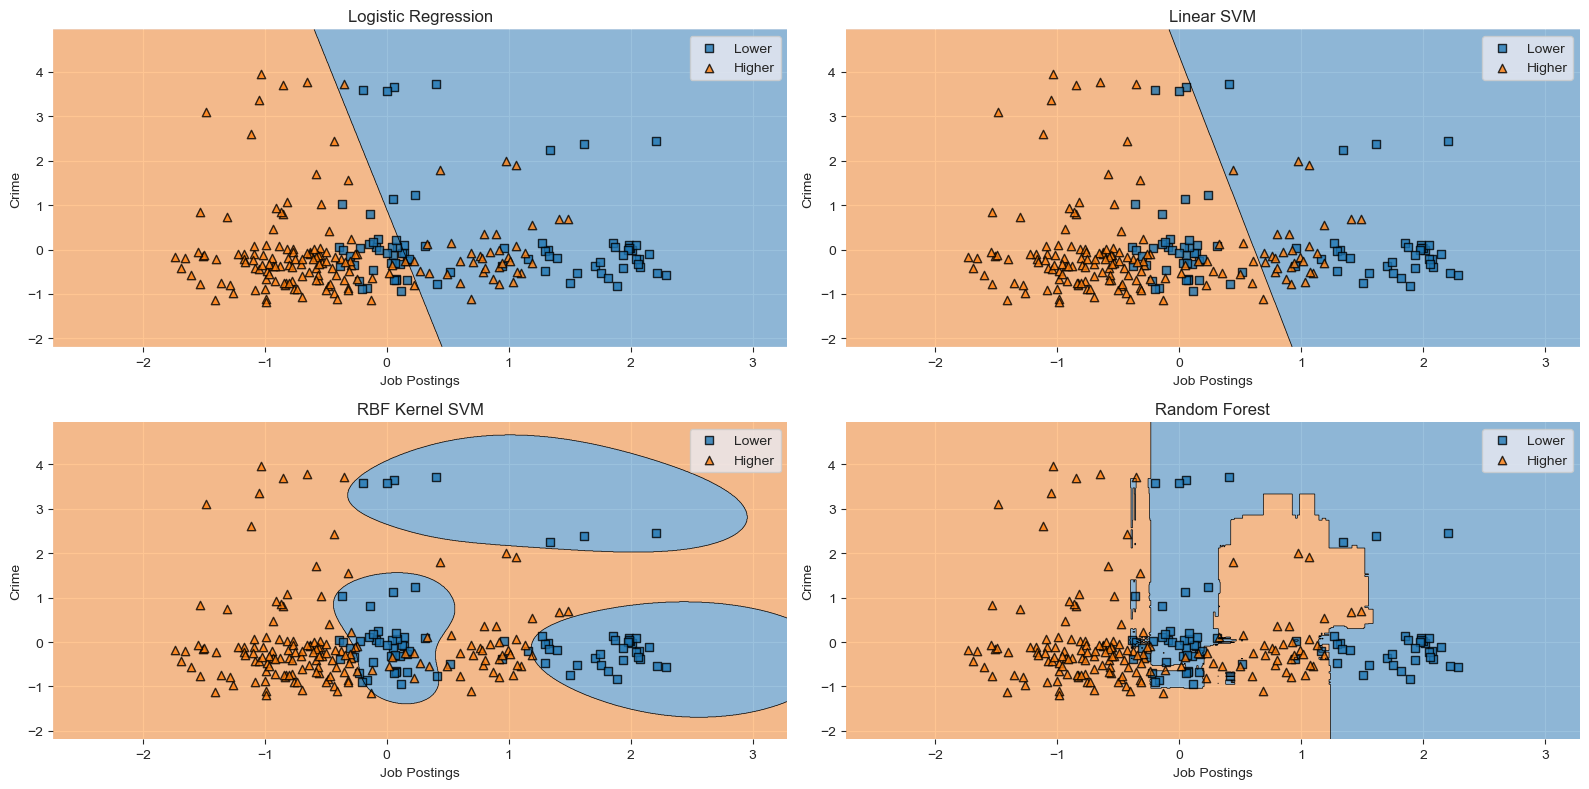

In [1530]:
clf_linear = LinearSVC(C = svm_linear.best_params_['C'])
clf_radial = SVC(kernel='rbf', gamma = 'scale', C = 50) # For illustration purpose of the radial kernel

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(16,8))
labels = ['Logistic Regression', 'Linear SVM', 'RBF Kernel SVM', 'Random Forest']

for clf, lab, grd in zip([logreg, clf_linear, clf_radial, rf_clf],
                         labels, [(0, 0), (0, 1), (1, 0), (1, 1)]):
    clf.fit(plot_X, plot_Y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=plot_X, y=plot_Y,
                                clf=clf, legend=2)
    plt.title(lab)
    plt.xlabel('Job Postings')
    plt.ylabel('Crime')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles,
              ['Lower', 'Higher'],   # put your names here
              fontsize=10,
              frameon=True)
    plt.title(lab)
plt.tight_layout()
plt.savefig('Visualizations/Classifier_visualization.png', dpi=300, bbox_inches="tight")
plt.show()